In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [62]:

df = pd.read_csv('C:\\Users\\user\\Desktop\\zz\\heart.csv')
# check the dimension of the data
print('Dataset dimension: ', df.shape)

# check the dataset's attributes
print('Attributes in the dataset: ', df.columns.values)
df.head()

Dataset dimension:  (298, 19)
Attributes in the dataset:  ['age' 'sex' 'cp' 'trestbps' 'chol' 'fbs' 'restecg' 'thalach' 'exang'
 'oldpeak' 'slope' 'ca' 'thal' 'target' 'normalized_age' 'normalized_chol'
 'normalized_trestbps' 'normalized_thalach' 'normalized_oldpeak']


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,normalized_age,normalized_chol,normalized_trestbps,normalized_thalach,normalized_oldpeak
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0,0.666667,1,4,0.807730,-0.047641
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0,0.000000,1,3,0.241164,1.759265
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0,0.000000,0,3,-1.066297,1.329049
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,0.333333,1,3,0.502656,-0.908073
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,1.000000,2,2,-1.894356,0.726747


In [63]:
# top level overview of the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 298 entries, 0 to 297
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  298 non-null    int64  
 1   sex                  298 non-null    int64  
 2   cp                   298 non-null    int64  
 3   trestbps             298 non-null    int64  
 4   chol                 298 non-null    int64  
 5   fbs                  298 non-null    int64  
 6   restecg              298 non-null    int64  
 7   thalach              298 non-null    int64  
 8   exang                298 non-null    int64  
 9   oldpeak              298 non-null    float64
 10  slope                298 non-null    int64  
 11  ca                   298 non-null    int64  
 12  thal                 298 non-null    int64  
 13  target               298 non-null    int64  
 14  normalized_age       298 non-null    float64
 15  normalized_chol      298 non-null    int

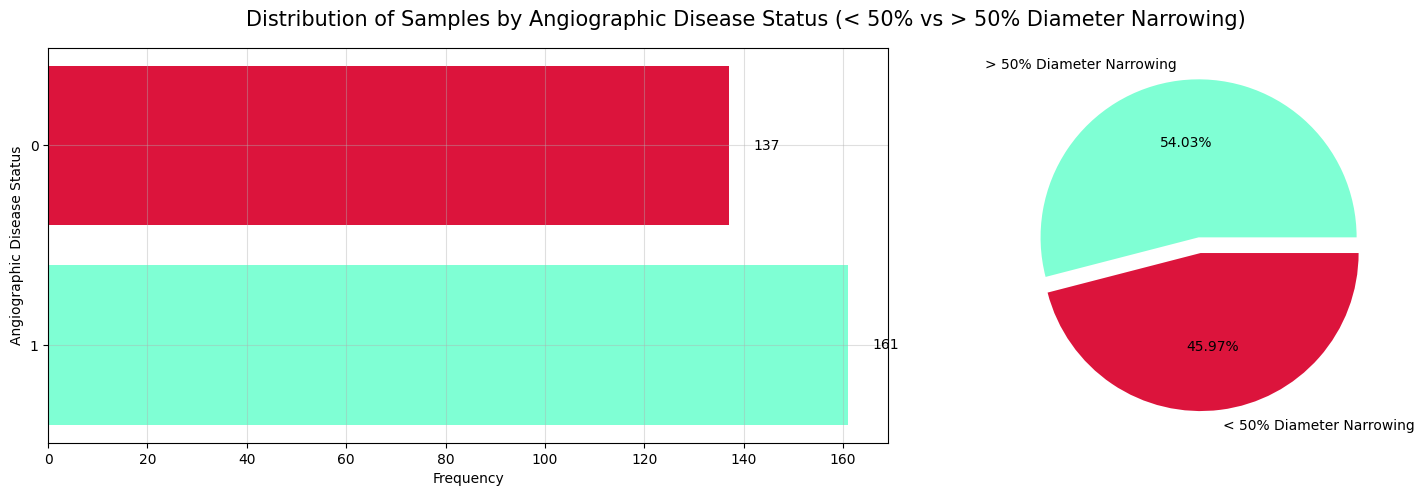

In [64]:
# distribution of samples by target label

target = df['target'].value_counts()
target_labels = ['> 50% Diameter Narrowing', '< 50% Diameter Narrowing']
colors = ['aquamarine', 'crimson']

figure, axes = plt.subplots(1,2, figsize=(15,5), gridspec_kw={'width_ratios':[1.5,1]})
axes[0].barh(y=target.index.astype(str), width=target.values, color=colors)
axes[0].set_xlabel('Frequency')
axes[0].set_ylabel('Angiographic Disease Status')
axes[0].grid(alpha=0.4)

for index, values in enumerate(target):
    axes[0].text(values+5, index, str(values), va='center')
    
axes[1].pie(target.values, labels=target_labels, explode=([0.05]*len(target.index)), autopct='%.2f%%', colors=colors)

figure.suptitle('Distribution of Samples by Angiographic Disease Status (< 50% vs > 50% Diameter Narrowing)', fontsize=15)
plt.tight_layout(pad=1)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_10380\3818081032.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




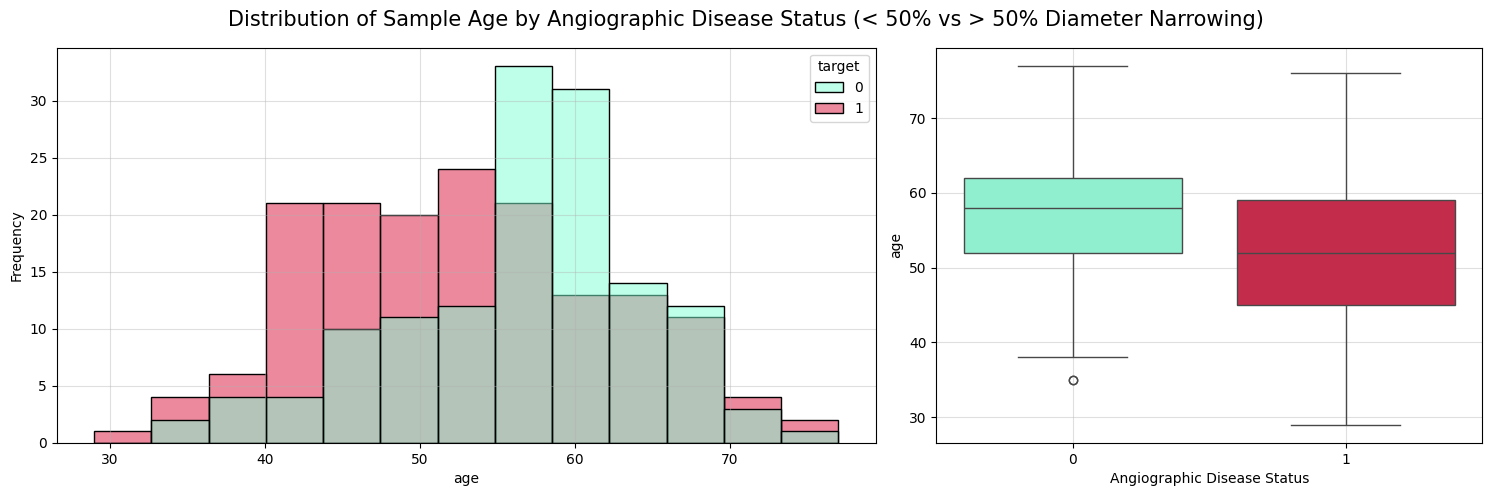

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,137.0,56.700730,7.905103,35.0,52.0,58.0,62.0,77.0
1,161.0,52.645963,9.521298,29.0,45.0,52.0,59.0,76.0


Test statistic:  3.9571
Test p-value:  0.0001
Reject the null hypothesis. The analysis reveals a statistically significant age difference between individuals with Angiographic Disease Status characterized by < 50% diameter narrowing and those with > 50% diameter narrowing.


In [65]:
from scipy.stats import ttest_ind
# visualization (histogram and boxplot)
figure, axes = plt.subplots(1,2, figsize=(15,5,), gridspec_kw={'width_ratios':[1.5,1]})
sns.histplot(data=data, x=data['age'], hue=data['target'], palette=colors, ax=axes[0])
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.4)
sns.boxplot(data=data, x=data['target'], y=data['age'], palette=colors, ax=axes[1])
axes[1].set_xlabel('Angiographic Disease Status')
axes[1].grid(alpha=0.4)
figure.suptitle('Distribution of Sample Age by Angiographic Disease Status (< 50% vs > 50% Diameter Narrowing)', fontsize=15)
plt.tight_layout(pad=1)
plt.show()

# display the 5 summary statistic
targets = data.groupby('target')
min_narrowing = targets.get_group(0)
sig_narrowing = targets.get_group(1)
display(targets['age'].describe())

# perform an independent T-Test
res = ttest_ind(min_narrowing['age'], sig_narrowing['age'])
test_stat = round(res[0], 4)
pvalue = round(res[1], 4)

print('Test statistic: ', test_stat)
print('Test p-value: ', pvalue)

alpha = 0.05
if pvalue < alpha:
    print('Reject the null hypothesis. The analysis reveals a statistically significant age difference between individuals with Angiographic Disease Status characterized by < 50% diameter narrowing and those with > 50% diameter narrowing.')
else:
    print('Failed to reject null hypothesis. Lack of evidence to conclude a statistically significant difference in age between individuals with Angiographic Disease Status characterized by < 50% diameter narrowing and those with > 50% diameter narrowing.')

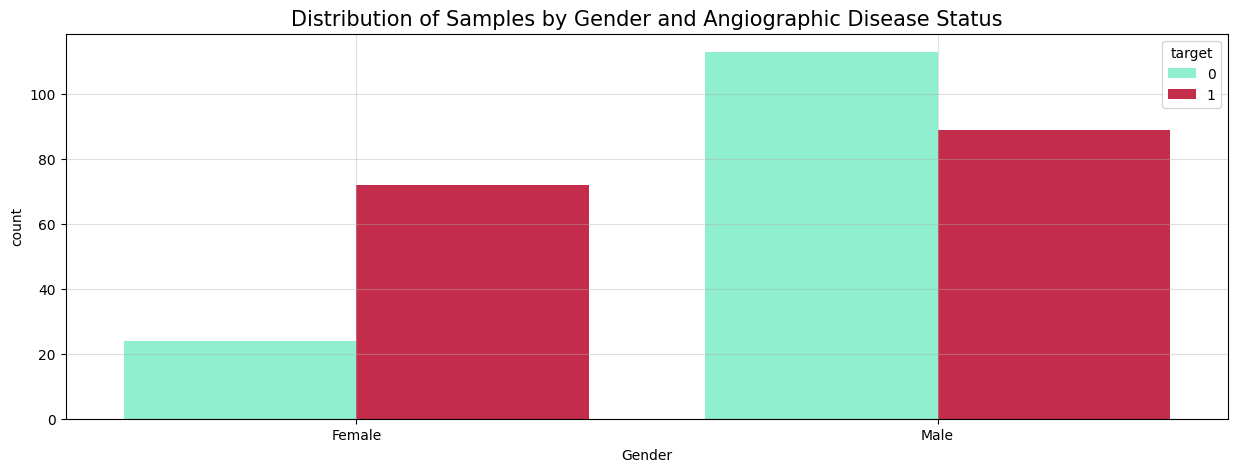

Contingency Table: 


target,0,1
sex,,
0,24,72
1,113,89


Expected Frequency: 


target,0,1
sex,,
0,44.134228,51.865772
1,92.865772,109.134228


Test statistic:  23.851
Test p-value:  0.0
Reject the null hypothesis, indicating a statistically significant link between gender and an increased likelihood of > 50% diameter narrowing.


In [66]:
from scipy.stats import chi2_contingency

# visualization (bar chart)
plt.figure(figsize=(15,5))
sns.countplot(data=data, x=data['sex'], hue=data['target'], palette=colors)
plt.xlabel('Gender')
plt.xticks(ticks=[0, 1], labels=['Female','Male'])
plt.title('Distribution of Samples by Gender and Angiographic Disease Status', fontsize=15)
plt.grid(alpha=0.4)
plt.show()

# perform a chi-square test
contingency_table = pd.crosstab(data['sex'], data['target'])
print('Contingency Table: ')
display(contingency_table)

res = chi2_contingency(contingency_table)
test_stat = round(res[0], 4)
pvalue = round(res[1], 4)
expected_freq = res[3]

print('Expected Frequency: ')
display(pd.DataFrame(expected_freq, columns=contingency_table.columns, index=contingency_table.index))
print('Test statistic: ', test_stat)
print('Test p-value: ', pvalue)

alpha = 0.05
if pvalue < alpha:
    print('Reject the null hypothesis, indicating a statistically significant link between gender and an increased likelihood of > 50% diameter narrowing.')
else:
    print('Failed to reject null hypothesis. Lack of evidence to conclude a statistically significant association between gender and the likelihood of > 50% diameter narrowing.')

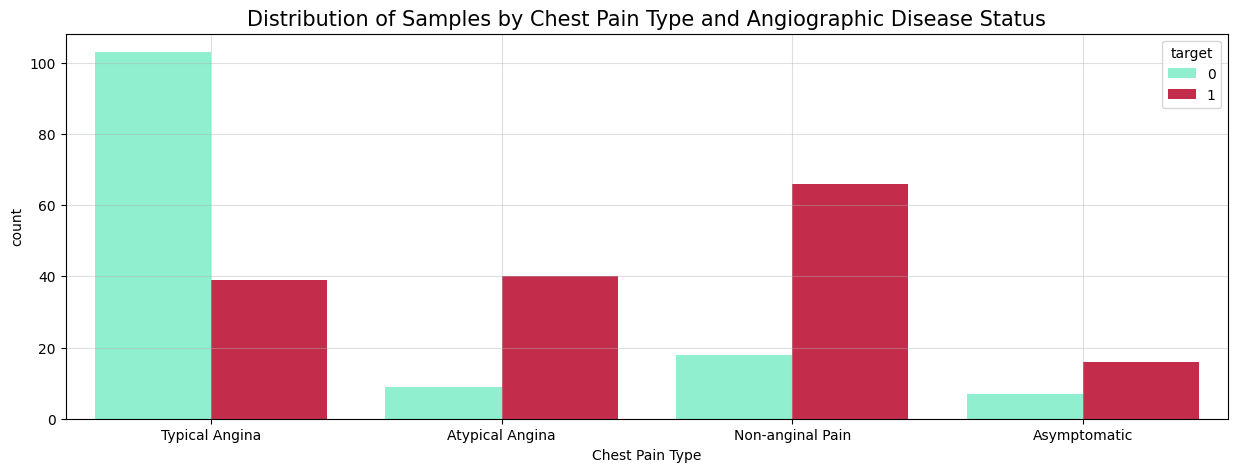

Contingency Table: 


target,0,1
cp,,
0,103,39
1,9,40
2,18,66
3,7,16


Expected Frequency: 


target,0,1
cp,,
0,65.281879,76.718121
1,22.526846,26.473154
2,38.617450,45.382550
3,10.573826,12.426174


Test statistic:  77.9805
Test p-value:  0.0
Reject the null hypothesis, indicating a statistically significant link between chest pain type and an increased likelihood of > 50% diameter narrowing.


In [67]:
# visualization (bar chart)
plt.figure(figsize=(15,5))
sns.countplot(data=data, x=data['cp'], hue=data['target'], palette=colors)
plt.xlabel('Chest Pain Type')
plt.xticks(ticks=[0, 1,2,3], labels=['Typical Angina', 'Atypical Angina', 'Non-anginal Pain', 'Asymptomatic'])
plt.title('Distribution of Samples by Chest Pain Type and Angiographic Disease Status', fontsize=15)
plt.grid(alpha=0.4)
plt.show()

# perform a chi-square test
contingency_table = pd.crosstab(data['cp'], data['target'])
print('Contingency Table: ')
display(contingency_table)

res = chi2_contingency(contingency_table)
test_stat = round(res[0], 4)
pvalue = round(res[1], 4)
expected_freq = res[3]

print('Expected Frequency: ')
display(pd.DataFrame(expected_freq, columns=contingency_table.columns, index=contingency_table.index))
print('Test statistic: ', test_stat)
print('Test p-value: ', pvalue)

alpha = 0.05
if pvalue < alpha:
    print('Reject the null hypothesis, indicating a statistically significant link between chest pain type and an increased likelihood of > 50% diameter narrowing.')
else:
    print('Failed to reject null hypothesis. Lack of evidence to conclude a statistically significant association between chest pain type and the likelihood of > 50% diameter narrowing.')

C:\Users\user\AppData\Local\Temp\ipykernel_10380\935088698.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




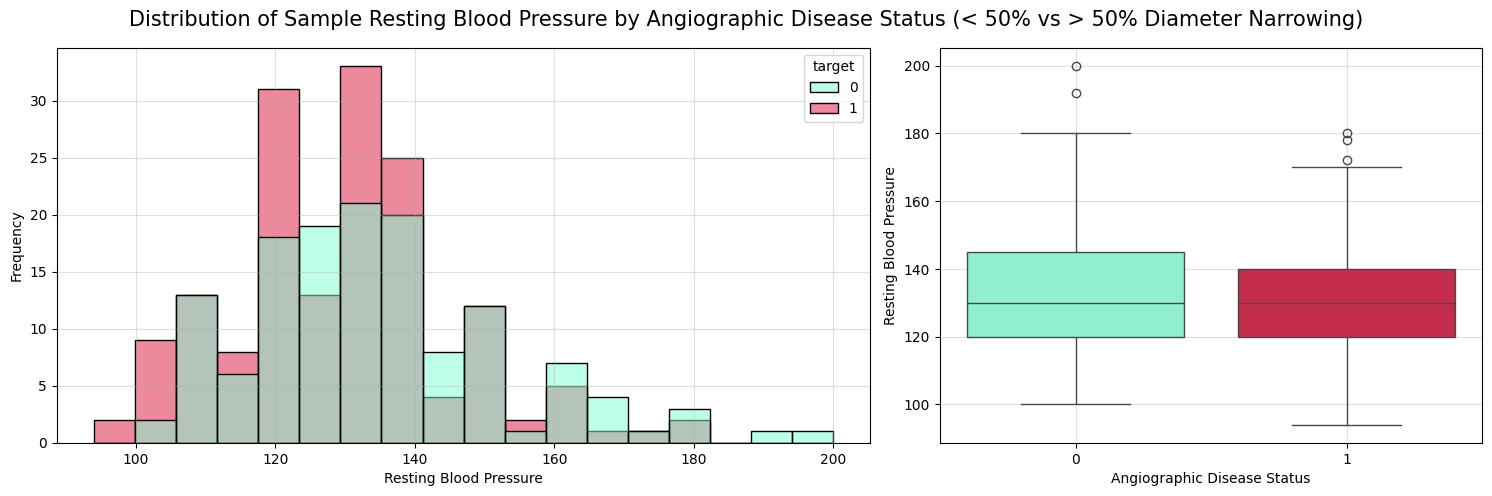

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,137.0,134.416058,18.797545,100.0,120.0,130.0,145.0,200.0
1,161.0,129.167702,16.323004,94.0,120.0,130.0,140.0,180.0


Test statistic:  2.5797
Test p-value:  0.0104
Reject the null hypothesis. The analysis reveals a statistically significant resting blood pressure difference between individuals with Angiographic Disease Status characterized by < 50% diameter narrowing and those with > 50% diameter narrowing.


In [68]:
# visualization (histogram and boxplot)
figure, axes = plt.subplots(1,2, figsize=(15,5,), gridspec_kw={'width_ratios':[1.5,1]})
sns.histplot(data=data, x=data['trestbps'], hue=data['target'], palette=colors, ax=axes[0])
axes[0].set_xlabel('Resting Blood Pressure')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.4)
sns.boxplot(data=data, x=data['target'], y=data['trestbps'], palette=colors, ax=axes[1])
axes[1].set_xlabel('Angiographic Disease Status')
axes[1].set_ylabel('Resting Blood Pressure')
axes[1].grid(alpha=0.4)
figure.suptitle('Distribution of Sample Resting Blood Pressure by Angiographic Disease Status (< 50% vs > 50% Diameter Narrowing)', fontsize=15)
plt.tight_layout(pad=1)
plt.show()

# display the 5 summary statistic
targets = data.groupby('target')
min_narrowing = targets.get_group(0)
sig_narrowing = targets.get_group(1)
display(targets['trestbps'].describe())

# perform an independent T-Test
res = ttest_ind(min_narrowing['trestbps'], sig_narrowing['trestbps'])
test_stat = round(res[0], 4)
pvalue = round(res[1], 4)

print('Test statistic: ', test_stat)
print('Test p-value: ', pvalue)

alpha = 0.05
if pvalue < alpha:
    print('Reject the null hypothesis. The analysis reveals a statistically significant resting blood pressure difference between individuals with Angiographic Disease Status characterized by < 50% diameter narrowing and those with > 50% diameter narrowing.')
else:
    print('Failed to reject null hypothesis. Lack of evidence to conclude a statistically significant difference in resting blood pressure between individuals with Angiographic Disease Status characterized by < 50% diameter narrowing and those with > 50% diameter narrowing.')

C:\Users\user\AppData\Local\Temp\ipykernel_10380\3342125469.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




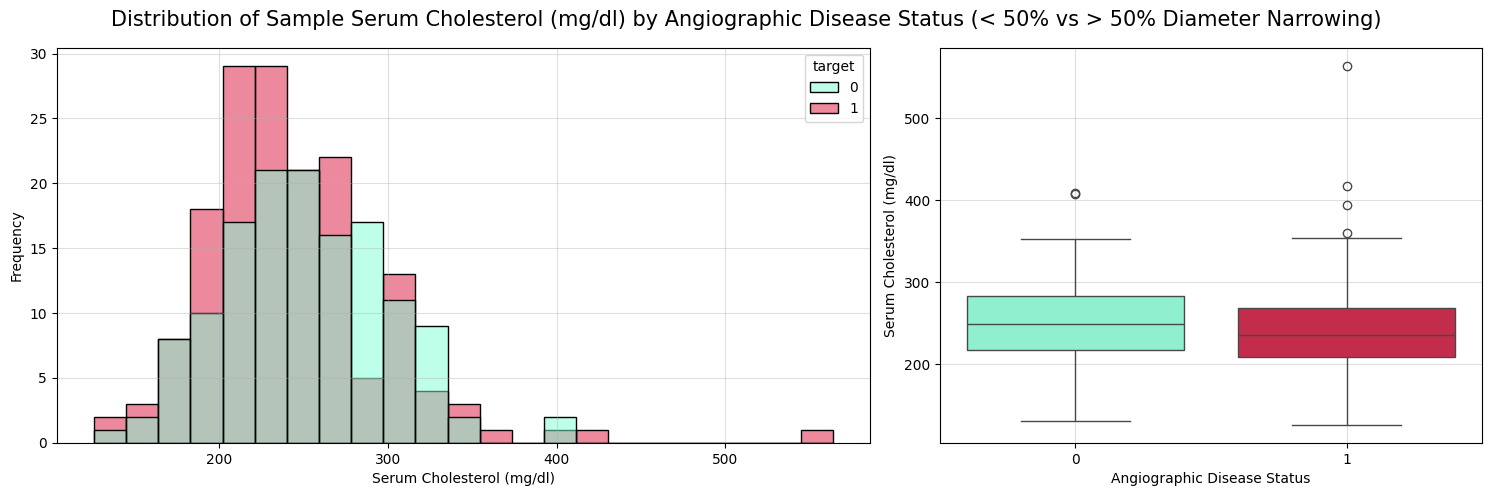

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,137.0,251.116788,49.634853,131.0,217.0,249.0,283.0,409.0
1,161.0,243.322981,53.633082,126.0,209.0,235.0,268.0,564.0


Test statistic:  1.2936
Test p-value:  0.1968
Failed to reject null hypothesis. Lack of evidence to conclude a statistically significant difference in serum cholesterol (mg/dl) between individuals with Angiographic Disease Status characterized by < 50% diameter narrowing and those with > 50% diameter narrowing.


In [69]:
# visualization (histogram and boxplot)
figure, axes = plt.subplots(1,2, figsize=(15,5,), gridspec_kw={'width_ratios':[1.5,1]})
sns.histplot(data=data, x=data['chol'], hue=data['target'], palette=colors, ax=axes[0])
axes[0].set_xlabel('Serum Cholesterol (mg/dl)')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.4)
sns.boxplot(data=data, x=data['target'], y=data['chol'], palette=colors, ax=axes[1])
axes[1].set_xlabel('Angiographic Disease Status')
axes[1].set_ylabel('Serum Cholesterol (mg/dl)')
axes[1].grid(alpha=0.4)
figure.suptitle('Distribution of Sample Serum Cholesterol (mg/dl) by Angiographic Disease Status (< 50% vs > 50% Diameter Narrowing)', fontsize=15)
plt.tight_layout(pad=1)
plt.show()

# display the 5 summary statistic
targets = data.groupby('target')
min_narrowing = targets.get_group(0)
sig_narrowing = targets.get_group(1)
display(targets['chol'].describe())

# perform an independent T-Test
res = ttest_ind(min_narrowing['chol'], sig_narrowing['chol'])
test_stat = round(res[0], 4)
pvalue = round(res[1], 4)

print('Test statistic: ', test_stat)
print('Test p-value: ', pvalue)

alpha = 0.05
if pvalue < alpha:
    print('Reject the null hypothesis. The analysis reveals a statistically significant serum cholesterol (mg/dl) difference between individuals with Angiographic Disease Status characterized by < 50% diameter narrowing and those with > 50% diameter narrowing.')
else:
    print('Failed to reject null hypothesis. Lack of evidence to conclude a statistically significant difference in serum cholesterol (mg/dl) between individuals with Angiographic Disease Status characterized by < 50% diameter narrowing and those with > 50% diameter narrowing.')

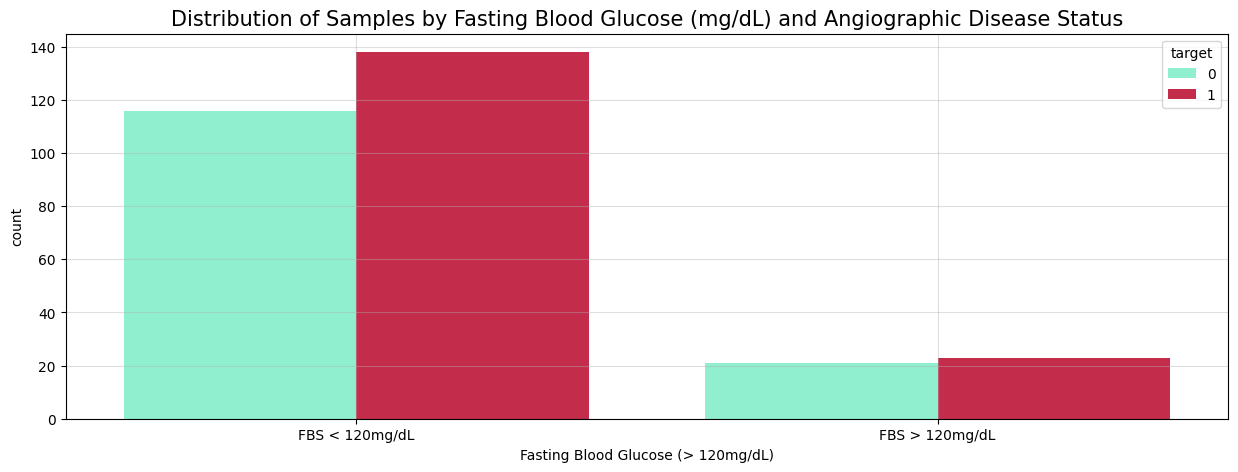

Contingency Table: 


target,0,1
fbs,,
0,116,138
1,21,23


Expected Frequency: 


target,0,1
fbs,,
0,116.771812,137.228188
1,20.228188,23.771812


Test statistic:  0.0079
Test p-value:  0.929
Failed to reject null hypothesis. Lack of evidence to conclude a statistically significant association between fasting blood glucose level and the likelihood of > 50% diameter narrowing.


In [70]:
# visualization (bar chart)
plt.figure(figsize=(15,5))
sns.countplot(data=data, x=data['fbs'], hue=data['target'], palette=colors)
plt.xlabel('Fasting Blood Glucose (> 120mg/dL)')
plt.xticks(ticks=[0,1], labels=['FBS < 120mg/dL', 'FBS > 120mg/dL'])
plt.title('Distribution of Samples by Fasting Blood Glucose (mg/dL) and Angiographic Disease Status', fontsize=15)
plt.grid(alpha=0.4)
plt.show()

# perform a chi-square test
contingency_table = pd.crosstab(data['fbs'], data['target'])
print('Contingency Table: ')
display(contingency_table)

res = chi2_contingency(contingency_table)
test_stat = round(res[0], 4)
pvalue = round(res[1], 4)
expected_freq = res[3]

print('Expected Frequency: ')
display(pd.DataFrame(expected_freq, columns=contingency_table.columns, index=contingency_table.index))
print('Test statistic: ', test_stat)
print('Test p-value: ', pvalue)

alpha = 0.05
if pvalue < alpha:
    print('Reject the null hypothesis, indicating a statistically significant association between fasting blood glucose level and an increased likelihood of > 50% diameter narrowing.')
else:
    print('Failed to reject null hypothesis. Lack of evidence to conclude a statistically significant association between fasting blood glucose level and the likelihood of > 50% diameter narrowing.')

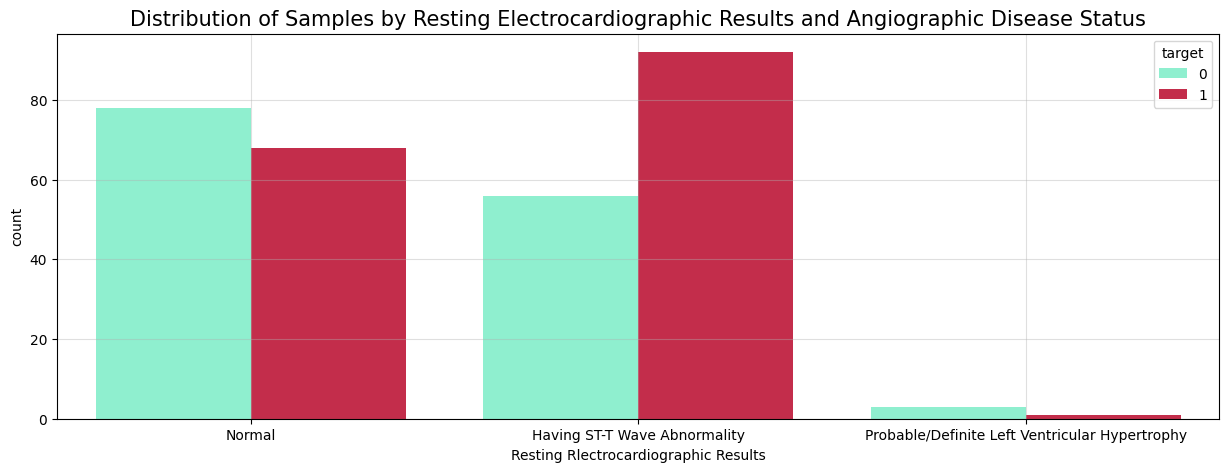

Contingency Table: 


target,0,1
restecg,,
0,78,68
1,56,92
2,3,1


Expected Frequency: 


target,0,1
restecg,,
0,67.120805,78.879195
1,68.040268,79.959732
2,1.838926,2.161074


Test statistic:  8.5644
Test p-value:  0.0138
Reject the null hypothesis, indicating a statistically significant association between resting electrocardiographic results and an increased likelihood of > 50% diameter narrowing.


In [71]:
# visualization (bar chart)
plt.figure(figsize=(15,5))
sns.countplot(data=data, x=data['restecg'], hue=data['target'], palette=colors)
plt.xlabel('Resting Rlectrocardiographic Results')
plt.xticks(ticks=[0,1,2], labels=['Normal','Having ST-T Wave Abnormality', 'Probable/Definite Left Ventricular Hypertrophy'])
plt.title('Distribution of Samples by Resting Electrocardiographic Results and Angiographic Disease Status', fontsize=15)
plt.grid(alpha=0.4)
plt.show()

# perform a chi-square test
contingency_table = pd.crosstab(data['restecg'], data['target'])
print('Contingency Table: ')
display(contingency_table)

res = chi2_contingency(contingency_table)
test_stat = round(res[0], 4)
pvalue = round(res[1], 4)
expected_freq = res[3]

print('Expected Frequency: ')
display(pd.DataFrame(expected_freq, columns=contingency_table.columns, index=contingency_table.index))
print('Test statistic: ', test_stat)
print('Test p-value: ', pvalue)

alpha = 0.05
if pvalue < alpha:
    print('Reject the null hypothesis, indicating a statistically significant association between resting electrocardiographic results and an increased likelihood of > 50% diameter narrowing.')
else:
    print('Failed to reject null hypothesis. Lack of evidence to conclude a statistically significant association between resting electrocardiographic results and the likelihood of > 50% diameter narrowing.')

C:\Users\user\AppData\Local\Temp\ipykernel_10380\2545199680.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




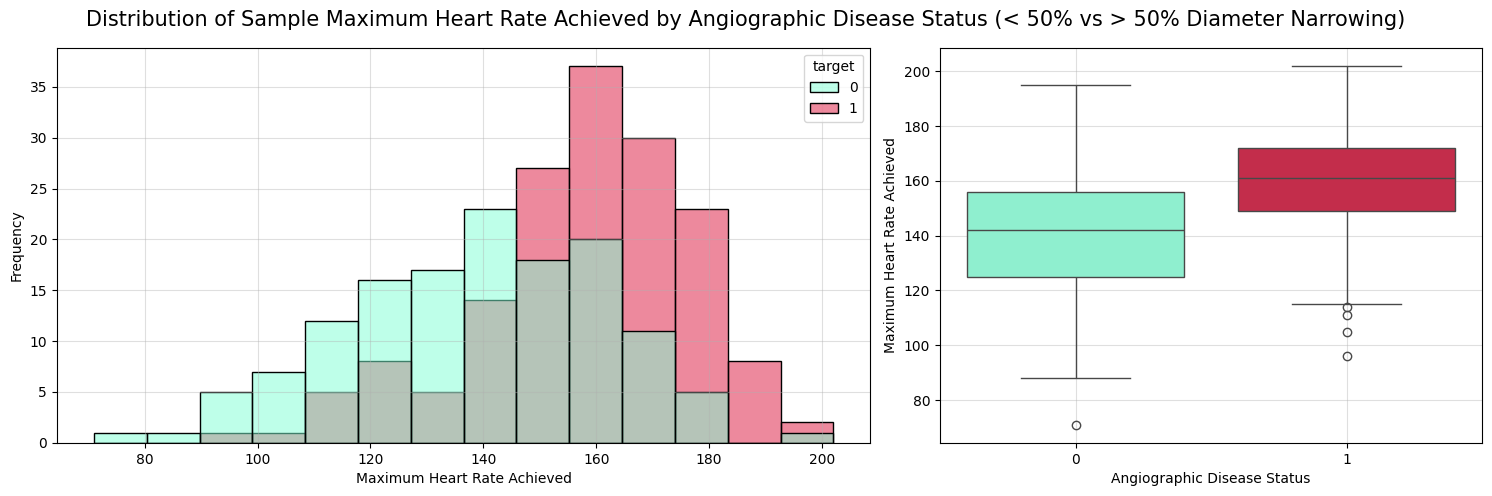

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,137.0,139.072993,22.679232,71.0,125.0,142.0,156.0,195.0
1,161.0,158.310559,19.291914,96.0,149.0,161.0,172.0,202.0


Test statistic:  -7.9127
Test p-value:  0.0
Reject the null hypothesis. The analysis reveals a statistically significant difference in maximum heart rate achieved between individuals with Angiographic Disease Status characterized by < 50% diameter narrowing and those with > 50% diameter narrowing.


In [72]:
# visualization (histogram and boxplot)
figure, axes = plt.subplots(1,2, figsize=(15,5,), gridspec_kw={'width_ratios':[1.5,1]})
sns.histplot(data=data, x=data['thalach'], hue=data['target'], palette=colors, ax=axes[0])
axes[0].set_xlabel('Maximum Heart Rate Achieved')
axes[0].set_ylabel('Frequency')
axes[0].grid(alpha=0.4)
sns.boxplot(data=data, x=data['target'], y=data['thalach'], palette=colors, ax=axes[1])
axes[1].set_xlabel('Angiographic Disease Status')
axes[1].set_ylabel('Maximum Heart Rate Achieved')
axes[1].grid(alpha=0.4)
figure.suptitle('Distribution of Sample Maximum Heart Rate Achieved by Angiographic Disease Status (< 50% vs > 50% Diameter Narrowing)', fontsize=15)
plt.tight_layout(pad=1)
plt.show()

# display the 5 summary statistic
targets = data.groupby('target')
min_narrowing = targets.get_group(0)
sig_narrowing = targets.get_group(1)
display(targets['thalach'].describe())

# perform an independent T-Test
res = ttest_ind(min_narrowing['thalach'], sig_narrowing['thalach'])
test_stat = round(res[0], 4)
pvalue = round(res[1], 4)

print('Test statistic: ', test_stat)
print('Test p-value: ', pvalue)

alpha = 0.05
if pvalue < alpha:
    print('Reject the null hypothesis. The analysis reveals a statistically significant difference in maximum heart rate achieved between individuals with Angiographic Disease Status characterized by < 50% diameter narrowing and those with > 50% diameter narrowing.')
else:
    print('Failed to reject null hypothesis. Lack of evidence to conclude a statistically significant difference in maximum heart rate achieved between individuals with Angiographic Disease Status characterized by < 50% diameter narrowing and those with > 50% diameter narrowing.')

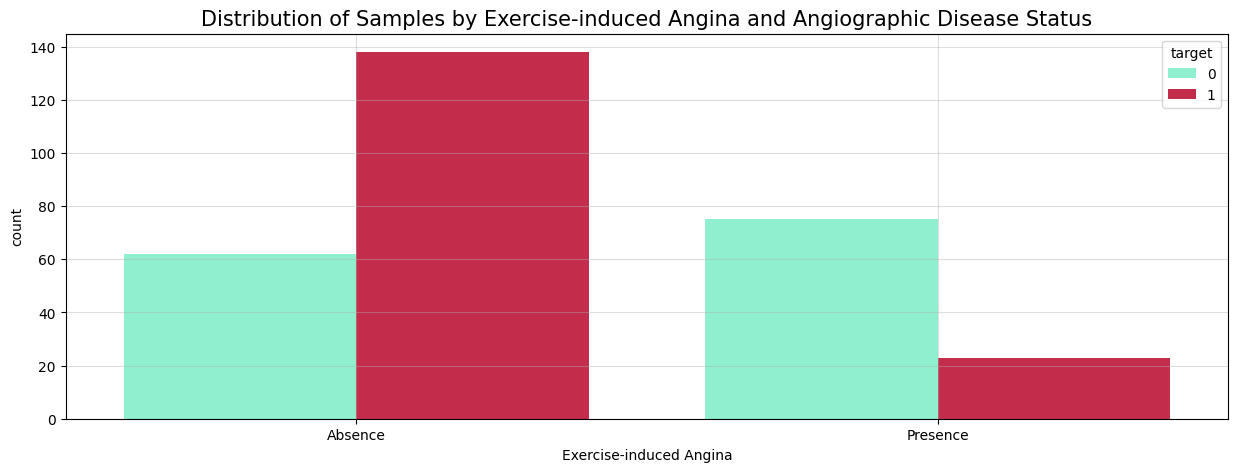

Contingency Table: 


target,0,1
exang,,
0,62,138
1,75,23


Expected Frequency: 


target,0,1
exang,,
0,91.946309,108.053691
1,45.053691,52.946309


Test statistic:  53.0772
Test p-value:  0.0
Reject the null hypothesis, indicating a statistically significant association between exercise-induced angina and an increased likelihood of > 50% diameter narrowing.


In [73]:
# visualization (bar chart)
plt.figure(figsize=(15,5))
sns.countplot(data=data, x=data['exang'], hue=data['target'], palette=colors)
plt.xlabel('Exercise-induced Angina')
plt.xticks(ticks=[0,1], labels=['Absence','Presence'])
plt.title('Distribution of Samples by Exercise-induced Angina and Angiographic Disease Status', fontsize=15)
plt.grid(alpha=0.4)
plt.show()

# perform a chi-square test
contingency_table = pd.crosstab(data['exang'], data['target'])
print('Contingency Table: ')
display(contingency_table)

res = chi2_contingency(contingency_table)
test_stat = round(res[0], 4)
pvalue = round(res[1], 4)
expected_freq = res[3]

print('Expected Frequency: ')
display(pd.DataFrame(expected_freq, columns=contingency_table.columns, index=contingency_table.index))
print('Test statistic: ', test_stat)
print('Test p-value: ', pvalue)

alpha = 0.05
if pvalue < alpha:
    print('Reject the null hypothesis, indicating a statistically significant association between exercise-induced angina and an increased likelihood of > 50% diameter narrowing.')
else:
    print('Failed to reject null hypothesis. Lack of evidence to conclude a statistically significant association between exercise-induced angina and the likelihood of > 50% diameter narrowing.')

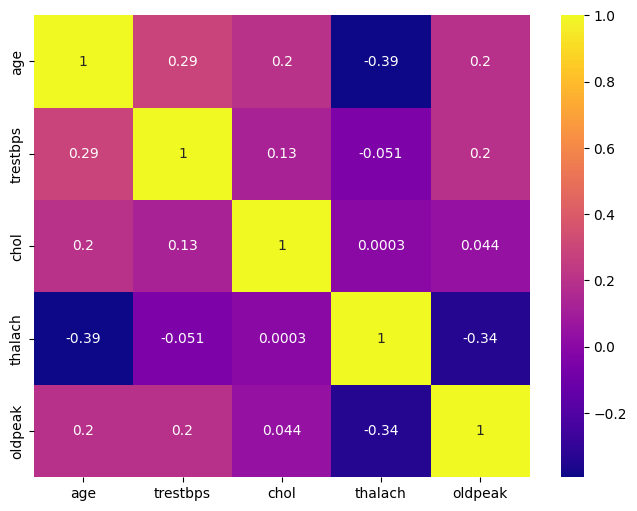

In [74]:
fil_data = data[['age','trestbps','chol','thalach','oldpeak']]

# compute the Pearson's correlation
correlation = fil_data.corr()

# visualize the correlation in heatmap
plt.figure(figsize=(8,6))
sns.heatmap(correlation, annot=True, cmap='plasma')
plt.show()

In [75]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(data, test_size=0.2, random_state=122)

# check the dimension of the dataset
print('Training dataset: ', train.shape)
print('Test dataset: ', test.shape)

Training dataset:  (238, 19)
Test dataset:  (60, 19)


In [76]:
# segregate the feature matrix and target vector
Xtrain = train.drop(columns=['target'], axis=1)
ytrain = train['target']

Xtest = test.drop(columns=['target'], axis=1)
ytest = test['target']

In [77]:
# scale the training and test data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xtest_scaled = scaler.transform(Xtest)

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

# create a Decision Tree Classifier
tree = DecisionTreeClassifier(random_state=122)

# Define the hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [2, 4]
}

# create the GridSearchCV object
grid_search_tree = GridSearchCV(tree, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# fit the grid search to the data
grid_search_tree.fit(Xtrain_scaled, ytrain)

# print the best parameters and the corresponding accuracy
print('Best Parameters: ', grid_search_tree.best_params_)
print('Best Accuracy: ', grid_search_tree.best_score_)

# get the best model
best_tree = grid_search_tree.best_estimator_

Best Parameters:  {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'random'}
Best Accuracy:  0.7942375886524824


In [79]:
df.shape

(298, 19)

In [80]:
df.dtypes

age                      int64
sex                      int64
cp                       int64
trestbps                 int64
chol                     int64
fbs                      int64
restecg                  int64
thalach                  int64
exang                    int64
oldpeak                float64
slope                    int64
ca                       int64
thal                     int64
target                   int64
normalized_age         float64
normalized_chol          int64
normalized_trestbps      int64
normalized_thalach     float64
normalized_oldpeak     float64
dtype: object

Data statistics such as the mean, median, and percentiles

In [81]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,normalized_age,normalized_chol,normalized_trestbps,normalized_thalach,normalized_oldpeak
count,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,298.000000,2.980000e+02,2.980000e+02
mean,54.510067,0.677852,0.959732,131.580537,246.906040,0.147651,0.523490,149.466443,0.328859,1.055369,1.395973,0.674497,2.312081,0.540268,0.224832,1.355705,2.426174,-1.490232e-17,5.960929e-17
std,9.030526,0.468085,1.033963,17.669293,51.893097,0.355350,0.526521,22.983830,0.470589,1.164162,0.617574,0.938202,0.614024,0.499214,0.312734,0.743763,1.410490,1.001682e+00,1.001682e+00
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3.419727e+00,-9.080729e-01
25%,48.000000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,1.000000,2.000000,-7.176411e-01,-9.080729e-01
50%,56.000000,1.000000,1.000000,130.000000,241.500000,0.000000,1.000000,152.500000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000,0.000000,2.000000,3.000000,1.322086e-01,-2.197277e-01
75%,61.000000,1.000000,2.000000,140.000000,275.000000,0.000000,1.000000,165.750000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000,0.333333,2.000000,4.000000,7.096706e-01,4.686176e-01
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,3.000000,3.000000,1.000000,1.000000,2.000000,4.000000,2.289519e+00,4.426603e+00


First 5 items in the dataset:

In [82]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,normalized_age,normalized_chol,normalized_trestbps,normalized_thalach,normalized_oldpeak
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0,0.666667,1,4,0.807730,-0.047641
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0,0.000000,1,3,0.241164,1.759265
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0,0.000000,0,3,-1.066297,1.329049
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,0.333333,1,3,0.502656,-0.908073
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,1.000000,2,2,-1.894356,0.726747


<hr style="border:none; height:0.9px;" />

# Preprocessing

Cleaning data and scaling it for better performance.

In [83]:
df.isna().sum()

age                    0
sex                    0
cp                     0
trestbps               0
chol                   0
fbs                    0
restecg                0
thalach                0
exang                  0
oldpeak                0
slope                  0
ca                     0
thal                   0
target                 0
normalized_age         0
normalized_chol        0
normalized_trestbps    0
normalized_thalach     0
normalized_oldpeak     0
dtype: int64

In [3]:
cols = ['age', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']

scaler = StandardScaler()

for col in cols:
    df[[col]] = scaler.fit_transform(df[[col]])

NameError: name 'df' is not defined

In [4]:
df.head()

NameError: name 'df' is not defined

Below I'll use a box plot to see if the data is imbalanced:

In [86]:

fig = px.histogram(df, x=df['target'], template='plotly_dark', nbins=2, width=800, height=400)
fig.update_layout(title='Data balance')

plt.show(fig)


As we can see, the proportions aren't very off and the data seems to be balanced well.

<hr style="border:none; height:0.9px;" />

# Dimension Reduction

Reducing the data dimension and noise to cluster targets using KMeans in a later graph.

In [87]:
import plotly.io as pio

# Dimension Reduction
pca = PCA(n_components=5)
ndf = df.drop(labels='target', axis=1)
pca_df = pca.fit_transform(ndf)

# create range enumerating pca feats
features = range(pca.n_components_)

fig = px.bar(x=features, y=pca.explained_variance_, template='plotly_dark', width=700)
fig.update_layout(title='PCA Features')
pio.show(fig, renderer="colab")


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

<hr style="border:none; height:0.9px;" />

# Choosing a model

Evaluating performance of models to choose from. Note decision tree classifier performed well but I'll use logisic regression instead

In [ ]:
X = df.drop(labels='target', axis=1).values
y = df['target'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12, test_size=0.2)

In [ ]:
import plotly.io as pio

models = {
    'Logistic Regression': LogisticRegression(), 
    'KNN': KNeighborsClassifier(), 
    'Decision Tree': DecisionTreeClassifier()
}

results = []

for model in models.values():
    kf = KFold(n_splits=5, shuffle=True, random_state=12)
    cv_results = cross_val_score(model, X_train, y_train, cv=kf) # by default returns accuracy
    results.append(cv_results)

df = pd.DataFrame(results).T
df.columns = models.keys()

df_melted = pd.melt(df, var_name='Models', value_name='Scores')

fig = px.box(df_melted, x='Models', y='Scores', facet_col='Models', 
             template='plotly_dark')
fig.update_xaxes(showticklabels=False)
fig.show()



ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In the chart above, we can see each model's bar diagram along with the median score depicted by the orange line.

KNN and LogisitcRegression both have accuracies ranging between 84 and 86%, while the decision tree seems to be up around 98%.

<hr style="border:none; height:0.9px;" />

# Logisitc Regression

In [5]:
logreg = LogisticRegression()
scaler = StandardScaler()

In [ ]:
pipeline = make_pipeline(scaler, logreg)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

y_pred_proba = pipeline.predict_proba(X_test)[:, 1] # slice second class positive

testing_accuracy = pipeline.score(X_test, y_test)
training_accuracy = pipeline.score(X_train, y_train)

print(classification_report(y_test, y_pred))
print('\n')
print(f'Training accuracy: {training_accuracy}')
print(f'Testing accuracy: {testing_accuracy}')

              precision    recall  f1-score   support

           0       0.72      0.82      0.77        22
           1       0.89      0.82      0.85        38

    accuracy                           0.82        60
   macro avg       0.80      0.82      0.81        60
weighted avg       0.82      0.82      0.82        60



Training accuracy: 0.8781512605042017
Testing accuracy: 0.8166666666666667


The precision and recall aren't terrible but definitely could be improved.

Below I'll create a ROC curve and find the AUC as well as plot a confusion matrix.

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500, template='plotly_dark'
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
print(f'AUC score: {roc_auc_score(y_pred, y_pred_proba)}')

AUC score: 1.0


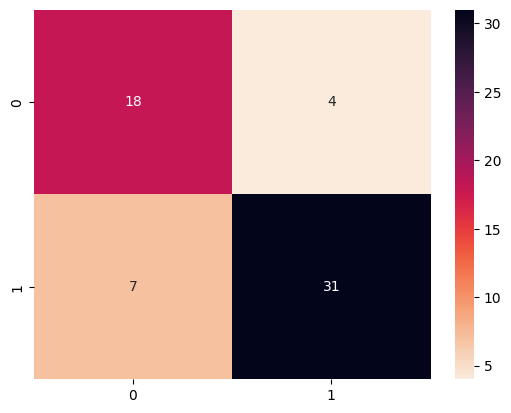

In [ ]:
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='rocket_r')
plt.show()

<hr style="border:none; height:0.9px;" />

# Clustering positive and negative cases

By using the elbow method below, I found the optimal number of clusters with the inertia lowering gradually to be 3. In this case however, I'll use two clusters for binary classification as I'm only interested in clustering positive and negative cases.

In [ ]:
ks = range(1, 6)
inertias = []

for k in ks:
    model = KMeans(n_clusters=k)
    
    model.fit(pca_df)
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)

fig = px.line(x=ks, y=inertias, markers=True, title='Optimal number of clusters', template='plotly_dark')
fig.update_layout(title='Number of clusters vs Inertia')
fig.update_xaxes(title_text="Number of clusters")
fig.update_yaxes(title_text="Inertia")
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [ ]:
model = KMeans(n_clusters=2)

cluster_labels = model.fit_predict(pca_df)

centroids = model.cluster_centers_

centroids_x = centroids[:, 0]
centroids_y = centroids[:, 1]

label_dict = {0: 'Negative cases', 1: 'Positive cases'}

fig = px.scatter(pca_df, x=pca_df[:, 0], y=pca_df[:, 1], color=cluster_labels, template='plotly_dark')
fig.update_layout(title='Clusters of positive and negative diagnosis')
fig.update_layout(xaxis_visible=False, yaxis_visible=False, 
                  xaxis=dict(showgrid=False, zeroline=False), 
                  yaxis=dict(showgrid=False, zeroline=False))
fig.add_trace(go.Scatter(x=centroids_x, y=centroids_y, mode='markers', 
                         marker=dict(color='red', size=6)))
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

<hr style="border:none; height:0.9px;" />

# Conclusion

The Logisitc Regression model has an accuracy of 83% as shown in the classification report along with the confusion matrix and ROC curve.

The KMeans clustering model also seems to cluster well even without the target label while the dimensions are reduced as well.